# Outline

Why this tutorial will be useful:
- This tutorial builds on previous exercises to expand your data science toolkit
- You will learn a handful of key techniques for visualizing high-dimensional data
- <font color='green'>As previously, you will solely need to change the code at positions marked with ```# <- adapt code here```</font>, however you are encouraged to experiment further

Main purpose of tutorial:
- Give exposure to popular techniques for qualitatively presenting relationships in high-dimensional datasets
- Provide visualization techniques that will be valuable in your own analyses

Additional purposes of tutorial:
- Give an overview of Principal Components Analysis (PCA), nonlinear correlation, and hierarchical clustering
- Learn to identify outlier samples in high-dimensional data

Stages:
- Stage 0: Load necessary components
- Stage 1: PCA (and plotting)
- Stage 2: Plotting Heatmaps

# Stage 0: Load necessary components

Refer to "02_homework" for a review of the basics of data and package import

In [95]:
# import packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re
import numpy as np

In [2]:
# import expression data
counts = pd.read_csv("/Users/rogangrant/Box/chaperome_student_course/chaperome_class/homework/Human.RPKM.txt",
                    sep = " ")

You will note that the gene identifiers are in ensembl format. The benefit of this is that these gene IDs will **never** change, whereas common gene names are highly variable and follow no clear convention. For the purposes of presenting data, however, most will prefer common gene names. For this exercise, we will substitute them.

In [3]:
# move ensembl IDs into a column for merging
counts = counts.reset_index()
counts.head()

,index,Brain.4wpc.1,Brain.4wpc.2,Brain.4wpc.3,Brain.5wpc.4,Brain.5wpc.5,Brain.7wpc.6,Brain.7wpc.7,Brain.7wpc.8,Brain.8wpc.9,...,Testis.youngTeenager.32,Testis.youngTeenager.33,Testis.oldTeenager.34,Testis.oldTeenager.35,Testis.youngAdult.36,Testis.youngAdult.37,Testis.youngAdult.38,Testis.youngMidAge.39,Testis.olderMidAge.40,Testis.Senior.41
0,ENSG00000000003,44.200566,48.583552,54.303912,52.563010,51.692866,32.022115,32.415882,28.242986,17.923539,...,16.224482,12.127216,21.493767,53.860000,30.283179,47.028724,20.952929,32.211466,29.945356,46.004925
1,ENSG00000000005,0.034822,0.000000,0.029186,0.492149,0.027758,0.361460,0.031059,0.026429,0.058898,...,0.546791,0.194143,0.100109,0.036588,0.042599,0.069795,0.159284,0.081255,0.049778,0.023723
2,ENSG00000000419,30.121638,21.981823,30.171390,34.598461,30.880156,22.483224,33.972168,22.174389,27.339891,...,30.085975,32.848579,32.689237,37.286060,36.735807,46.579990,30.329534,46.171946,36.695924,36.674850
3,ENSG00000000457,3.338827,3.658617,3.362251,3.474143,3.685258,2.467778,3.276239,2.432008,2.565086,...,1.920449,2.454734,2.231525,1.959682,2.383913,2.217096,2.335655,2.035747,2.991544,2.044109
4,ENSG00000000460,9.343823,9.300939,10.590018,8.313510,10.972311,5.504920,5.748965,5.678805,3.208603,...,2.161349,3.295901,3.835352,3.420894,3.934401,4.966480,5.155973,2.664176,5.461381,3.396201


In [4]:
# Conversion
# import conversion table
gene_conversions = pd.read_csv("/Users/rogangrant/Box/chaperome_student_course/chaperome_class/homework/human_gene_name_conversions.csv")
name_conversions = gene_conversions[["ensembl_gene_id", "external_gene_name"]]
name_conversions.head()

,ensembl_gene_id,external_gene_name
0,ENSG00000210049,MT-TF
1,ENSG00000211459,MT-RNR1
2,ENSG00000210077,MT-TV
3,ENSG00000210082,MT-RNR2
4,ENSG00000209082,MT-TL1


In [5]:
# perform merge
counts = pd.merge(counts,
                 name_conversions,
                 left_on = "index",
                 right_on = "ensembl_gene_id",
                 how = "inner") #take intersection of datasets
counts.head()

,index,Brain.4wpc.1,Brain.4wpc.2,Brain.4wpc.3,Brain.5wpc.4,Brain.5wpc.5,Brain.7wpc.6,Brain.7wpc.7,Brain.7wpc.8,Brain.8wpc.9,...,Testis.oldTeenager.34,Testis.oldTeenager.35,Testis.youngAdult.36,Testis.youngAdult.37,Testis.youngAdult.38,Testis.youngMidAge.39,Testis.olderMidAge.40,Testis.Senior.41,ensembl_gene_id,external_gene_name
0,ENSG00000000003,44.200566,48.583552,54.303912,52.563010,51.692866,32.022115,32.415882,28.242986,17.923539,...,21.493767,53.860000,30.283179,47.028724,20.952929,32.211466,29.945356,46.004925,ENSG00000000003,TSPAN6
1,ENSG00000000005,0.034822,0.000000,0.029186,0.492149,0.027758,0.361460,0.031059,0.026429,0.058898,...,0.100109,0.036588,0.042599,0.069795,0.159284,0.081255,0.049778,0.023723,ENSG00000000005,TNMD
2,ENSG00000000419,30.121638,21.981823,30.171390,34.598461,30.880156,22.483224,33.972168,22.174389,27.339891,...,32.689237,37.286060,36.735807,46.579990,30.329534,46.171946,36.695924,36.674850,ENSG00000000419,DPM1
3,ENSG00000000457,3.338827,3.658617,3.362251,3.474143,3.685258,2.467778,3.276239,2.432008,2.565086,...,2.231525,1.959682,2.383913,2.217096,2.335655,2.035747,2.991544,2.044109,ENSG00000000457,SCYL3
4,ENSG00000000460,9.343823,9.300939,10.590018,8.313510,10.972311,5.504920,5.748965,5.678805,3.208603,...,3.835352,3.420894,3.934401,4.966480,5.155973,2.664176,5.461381,3.396201,ENSG00000000460,C1orf112


In [6]:
#remove unnecessary columns
counts = counts.set_index("external_gene_name")
counts = counts.drop(["index", "ensembl_gene_id"], axis = 1) #axis = 1 selects columns
counts.head()

,Brain.4wpc.1,Brain.4wpc.2,Brain.4wpc.3,Brain.5wpc.4,Brain.5wpc.5,Brain.7wpc.6,Brain.7wpc.7,Brain.7wpc.8,Brain.8wpc.9,Brain.8wpc.10,...,Testis.youngTeenager.32,Testis.youngTeenager.33,Testis.oldTeenager.34,Testis.oldTeenager.35,Testis.youngAdult.36,Testis.youngAdult.37,Testis.youngAdult.38,Testis.youngMidAge.39,Testis.olderMidAge.40,Testis.Senior.41
external_gene_name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,44.200566,48.583552,54.303912,52.563010,51.692866,32.022115,32.415882,28.242986,17.923539,27.117528,...,16.224482,12.127216,21.493767,53.860000,30.283179,47.028724,20.952929,32.211466,29.945356,46.004925
TNMD,0.034822,0.000000,0.029186,0.492149,0.027758,0.361460,0.031059,0.026429,0.058898,0.093092,...,0.546791,0.194143,0.100109,0.036588,0.042599,0.069795,0.159284,0.081255,0.049778,0.023723
DPM1,30.121638,21.981823,30.171390,34.598461,30.880156,22.483224,33.972168,22.174389,27.339891,31.540324,...,30.085975,32.848579,32.689237,37.286060,36.735807,46.579990,30.329534,46.171946,36.695924,36.674850
SCYL3,3.338827,3.658617,3.362251,3.474143,3.685258,2.467778,3.276239,2.432008,2.565086,2.826391,...,1.920449,2.454734,2.231525,1.959682,2.383913,2.217096,2.335655,2.035747,2.991544,2.044109
C1orf112,9.343823,9.300939,10.590018,8.313510,10.972311,5.504920,5.748965,5.678805,3.208603,4.190815,...,2.161349,3.295901,3.835352,3.420894,3.934401,4.966480,5.155973,2.664176,5.461381,3.396201


# Stage 1: PCA (and plotting)

Now that we have our data in a workable format, we can perform principal components analysis. Volumes have been written on this technique, and with good reason; it is extremely powerful for handling high-dimensional data. Back in the days of qPCR, experiments would generate expression data for just a few genes. If you want to compare patterns of expression for a group of samples for just two genes, the procedure is very simple: plot expression of gene A on the X-axis, and gene B on the Y-axis for each sample. A third gene could even go on the Z-axis for a 3D plot. RNA-seq, on the other hand, generates data for every transcript in the human genome (43256, in this case). Plotting this number of dimensions is effectively impossible in our 3-dimensional universe. 

How do we get past this? One option is to plot each dimension (gene) individually, but this is fairly tedious. We will see how this is made more possible with heatmaps later. Alternatively, we can reduce the dimensionality of our data. While this clearly has the risk of reducing information value (and certainly does, to some degree), this turns out to be an excellent way to compare high-dimensional datasets in a semi-quantitative way. Without going too far into the linear algebra, PCA identifies features (genes, in this case) which are highly correlated, and groups them together into a single "principal component". This is often referred to an eigenvector, which is the linear combination of these features into a single "eigenfeature". PCA then iteratively generates additional principal components from groups of features that are correlated, but orthogonal (not correlated) to existing principal components. Convention is generally to generate 2-3 principal components.

This works particularly well with gene expression data, because groups of genes are often co-regulated. By examining the contribution of each gene to each eigenvector (or "eigengene", if you will), one can even begin the infer the biological significance. Most simply, however, PCA offers an excellent way to roughly compare the relationship between datasets for a given experiment. By examining how the samples cluster together on a PCA plot, we can better understand which samples behave similarly.

Let's try this with the complete human dataset.

## Stage 1.1: pre-processing and PCA calculation

To perform PCA, we need to manipulate the expression matrix in the following ways:
1. Transpose the dataset, or flip it so that genes are columns, and samples are rows
2. Scale expression values so that they vary from 0 to 1 and contribute equally to the PCA
3. Center expression values about 0 (this is performed implicitly)

In [28]:
#transpose
counts_for_pca = counts.transpose()
counts_for_pca = counts_for_pca.rename_axis(["sample"])
counts_for_pca.head()

external_gene_name,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,BX649601.1,AL157392.4,AL133215.3,AL391069.3,AL354760.1,OR6R2P,AL139339.2,AC104836.1,AC008264.2,AC098479.1
sample,,,,,,,,,,,,,,,,,,,,,
Brain.4wpc.1,44.200566,0.034822,30.121638,3.338827,9.343823,0.161379,0.110143,16.635541,5.276395,29.267179,...,0.539067,0.162501,0.000000,0.000000,0.348759,0.0,0.383993,0.043359,0.022539,0.546068
Brain.4wpc.2,48.583552,0.000000,21.981823,3.658617,9.300939,0.140486,0.092615,13.855218,4.010577,26.765158,...,0.775664,0.128603,0.297107,0.000000,0.483011,0.0,0.742843,0.034314,0.011892,0.000000
Brain.4wpc.3,54.303912,0.029186,30.171390,3.362251,10.590018,0.202891,0.057698,16.888502,4.486296,25.214784,...,0.821495,0.136201,0.104887,0.000000,0.219236,0.0,0.214564,0.109024,0.037783,0.915380
Brain.5wpc.4,52.563010,0.492149,34.598461,3.474143,8.313510,0.152055,0.727902,16.023538,4.833899,24.164240,...,0.666970,0.170126,0.000000,0.000000,0.365122,0.0,0.625348,0.090786,0.023597,0.762252
Brain.5wpc.5,51.692866,0.027758,30.880156,3.685258,10.972311,0.102916,0.153653,16.606907,5.043125,28.461090,...,0.703181,0.259079,0.299271,0.185826,0.417024,0.0,0.476161,0.069128,0.011978,0.580403


In [56]:
#scale from 0 to 1
counts_for_pca_scaled = StandardScaler().fit_transform(counts_for_pca)

# center and perform PCA
pca = PCA(n_components=3) # we will do 3 PCs
PCs = pca.fit_transform(counts_for_pca_scaled)
pca_dataframe = pd.DataFrame(data = PCs,
                           columns = ['PC1', 'PC2', 'PC3'])
pca_dataframe.head()

,PC1,PC2,PC3
0,-38.268538,-0.966672,-97.702799
1,-37.890574,-1.131430,-92.723271
2,-33.139981,8.716752,-85.614179
3,-33.501748,-2.242136,-88.904116
4,-39.477145,-3.599889,-92.192326


## Stage 1.2: visualization 

Now that we have our PCA data, let's add our metadata and plot it

In [57]:
#add metadata

pca_dataframe["sample"] = counts_for_pca.index
#make sample names match larger dataset (which includes a species prefix)
for i in range(pca_dataframe["sample"].size):
    pca_dataframe["sample"][i] = "Human." + pca_dataframe["sample"][i]

md = pd.read_csv("/Users/rogangrant/Box/chaperome_student_course/chaperome_class/homework/Kaessman_sample_metadata.csv")
pca_dataframe = pd.merge(pca_dataframe,
                        md,
                        on = "sample",
                        how = "inner")
pca_dataframe.head()

/Users/rogangrant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,PC1,PC2,PC3,sample,organism,tissue,age,replicate
0,-38.268538,-0.966672,-97.702799,Human.Brain.4wpc.1,Human,Brain,4wpc,1
1,-37.890574,-1.131430,-92.723271,Human.Brain.4wpc.2,Human,Brain,4wpc,2
2,-33.139981,8.716752,-85.614179,Human.Brain.4wpc.3,Human,Brain,4wpc,3
3,-33.501748,-2.242136,-88.904116,Human.Brain.5wpc.4,Human,Brain,5wpc,4
4,-39.477145,-3.599889,-92.192326,Human.Brain.5wpc.5,Human,Brain,5wpc,5


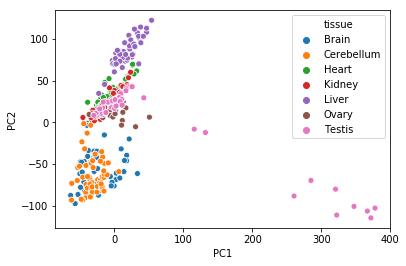

In [66]:
# plot scatter
sns.scatterplot(data = pca_dataframe,
                x = "PC1",
                y = "PC2",
               hue = "tissue")

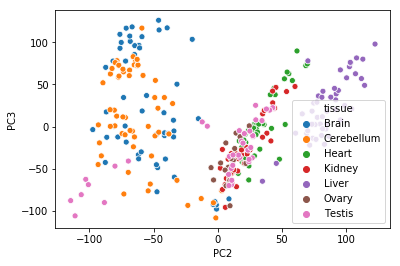

In [64]:
sns.scatterplot(data = pca_dataframe,
                x = "PC2",
                y = "PC3",
               hue = "tissue")

As expected, samples corresponding to a single tissue cluster together, as do similar tissues. It does appear that some testis samples may have been mishandled or differently processed in some way, as evidenced by their strange behavior on PC1. For more interesting visualization, try this for a tissue of interest for all organisms in the dataset. The trends are quite revealing.

# Stage 2: Plotting heatmaps

In the simplest sense, heatmaps are just visualizations of a matrix. The rows and columns are the same, and the color or intensity of a given sample corresponds to its value. In general, brighter colors correspond to higher values, whereas "cooler" colors correspond to lower values. 

It is quite common to "cluster" rows and/or columns, such that more similar samples are organized together; this allows for better pattern recognition. While many clustering methods exist, they are all similar in principle. First, pairwise "distances" are calculated for each sample. This can be anything from correlation coefficients, to average differences between measurements, and depends largely on the type of data and the comparison. In all cases, the most similar datasets are identified iteratively, and joined in reverse, stepwise order until all datasets have been joined. This then gives an approximation of dataset similarity. By sorting the samples in order of similarity, much more obvious patterns tend to emerge. We will see this firsthand.

## Stage 2.1: average expression values by condition

As with any good biological dataset, we have many replicates per sample. In order to reduce the complexity of our plot, we will average expression for each condition. As before, consider what impact a mean may have on these representations, as compared to median or other statistics.

To do this, we will have to derive a new matrix from our raw data, with just one column per sample. Have a look at the old matrix as necessary to get an idea of how this will work.

In [98]:
#first, make the new column names, which will be the unique values after stripping replicate number
mean_cols = counts.columns
for i in range(len(mean_cols)):
    mean_cols[i] = mean_cols[i][0:(len(mean_cols[i]) - 2)]
mean_cols = np.unique(mean_cols)
mean_cols

TypeError: Index does not support mutable operations